# Extract values to be able to synchronise Miniscope, webcam and ephys

Webcam not synchronised at the moment because there is no conflict between OE_miniscope and miniscope timestamps. 

## Initialize

### Load the required packages (and many more that are not useful)

In [4]:
import numpy as np
import csv
from pathlib import Path
import xarray as xr
import pandas as pd
import matplotlib.pyplot as plt
from ipyfilechooser import FileChooser

## Import the files

### Define paths

In [6]:
dpath = "//10.69.168.1/crnldata/waking/audrey_hay/L1imaging/AnalysedMarch2023/Gaelle/Baseline_recording"
try:
    %store -r dpath
except:
    print("data not in strore")
    dpath ="//10.69.168.1/crnldata/waking/audrey_hay/L1imaging/AnalysedMarch2023/Gaelle/Baseline_recording"

fc1 = FileChooser(dpath,select_default=True, show_only_dirs = True, title = "<b>Session folder</b>")
display(fc1)

# Sample callback function
def update_my_folder(chooser):
    global dpath
    dpath = chooser.selected
    %store dpath
    return 

# Register callback function
fc1.register_callback(update_my_folder)

FileChooser(path='\\10.69.168.1\crnldata\waking\audrey_hay\L1imaging\AnalysedMarch2023\Gaelle\Baseline_recordi…

Stored 'dpath' (str)
Stored 'dpath' (str)
Stored 'dpath' (str)


### Get timestamps

In [25]:
folder = Path(dpath)

file_path= f'{folder}/V4_Miniscope/timeStamps.csv'
stamps_miniscope = pd.read_csv(file_path)

file_path= f'{folder}/OpenEphys/timeStamps.npy'
stamps_OE = np.load(file_path)

file_path= f'{folder}/TTL/timeStamps.npy'
stamps_ttl = np.load(file_path)

### Detect frame drops

Compute the delta between each time stamp in the miniscope timestamp file, this allows for determining if and when a frame was dropped.

In [35]:
stamps_miniscope_time = stamps_miniscope['Time Stamp (ms)']
delay_stamps = []
number_frames = stamps_miniscope['Time Stamp (ms)'].count()
for i in range(number_frames -1):
    delay_stamps.append(stamps_miniscope_time[i+1] - stamps_miniscope_time[i])

freq_acq = round(1000/(sum(delay_stamps)/len(delay_stamps)))
print("The calculated frame rate is : {} Hz".format(freq_acq) )

The calculated frame rate is : 20 Hz


In [36]:
delaystampMini = (1000/freq_acq)*1.5
delaystampOE = (25000/freq_acq)*1.5*2

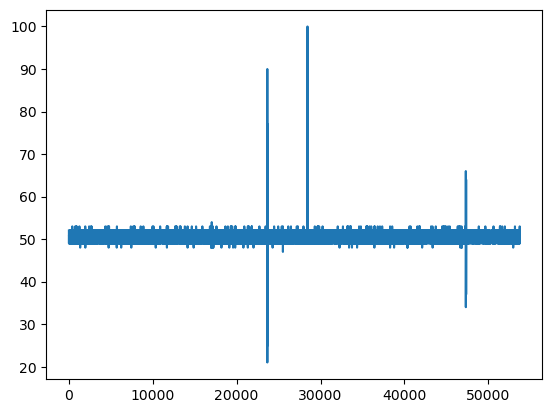

Threshold dropped frame= 75.0


In [42]:
plt.close()
plt.plot(np.diff(stamps_miniscope_time))
plt.show()
print('Threshold dropped frame=',delaystampMini)

In [34]:
delay_stamps = []
dropped_frames = []
number_frames = stamps_miniscope['Time Stamp (ms)'].count()
for i in range(number_frames -1):
    delay_stamps.append(stamps_miniscope_time[i+1] - stamps_miniscope_time[i])
    if delay_stamps[i] > delaystampMini:
        dropped_frames.append(i)

print("{} frame(s) were dropped : {}".format(len(dropped_frames),dropped_frames))

3 frame(s) were dropped : [23659, 23698, 28448]


### Normalise time stamps from open ephys signal

In [43]:
A = []
file_path= f'{folder}/sync_messages.txt'
with open(file_path, "r") as f:
    lines = f.readlines()
# Loop through all lines, ignoring header.
# take last element to list (i.e. the process name)
    for l in lines[1:]:
        A.append(l.split()[-1])
print("it reads {}".format(A))

# remove acquisition frequency that is normally always 25 kHz
initial_OE_start = int(' '.join([x.split('@')[0] for x in A]))#int(''.join([x.strip('@25000Hz') for x in A]))
acqFreqOE = int(' '.join([x[:-2].split('@')[1] for x in A]))


it reads ['413951488@25000Hz']


In [44]:
acquisition_mini_start_n = (stamps_ttl[0]-initial_OE_start)/acqFreqOE
acquisition_mini_start_a = stamps_ttl[0]

outSumm = pd.Series([acquisition_mini_start_n, acquisition_mini_start_a, freq_acq, dropped_frames],
              index=['Miniscope start from 0', 'Miniscope start from Acq time soft', 'mini acq freq', 'dropped frames'])
outSumm


Miniscope start from 0                              0.30124
Miniscope start from Acq time soft                413959019
mini acq freq                                            20
dropped frames                        [23659, 23698, 28448]
dtype: object

In [45]:
filenameOut = folder / f'SynchroFile.xlsx'
writer = pd.ExcelWriter(filenameOut)
outSumm.to_excel(writer)
writer.close()       